In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score



from datetime import datetime    # 수행 시간 측정을 위해.

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils

import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet

# Project-1

- imageDataGenerator와 TL을 이용해서 오버피팅이 최소가 될 수 있도록 90% 이상의 정확도 달성
- 만약 오버피팅이 심하고 90%이상의 성능이 나오지 않는다면, 문제점과 해결 방안을 찾아본다.

### 경로설정

In [2]:
ROOT_DIR = "C:\\Users\\owner\\PythonWork\\AI\\content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "brain_tumor")

TRAIN_DATA_ROOT_DIR =  os.path.join(DATA_ROOT_DIR, "Training")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Testing")

### 데이터셋 가져오기

In [3]:
#### Colab ver.

from google.colab import drive

drive.mount("/content/")

shutil.copy(os.path.join("/content/My drive/Colab Notebooks/", "archive.zip")) # Colab Notebooks에 파일을 올려놨다고 가정

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, "archive.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

ModuleNotFoundError: No module named 'google.colab'

In [3]:
#### PC ver.

with zipfile.ZipFile(os.path.join(ROOT_DIR, "archive.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

### 정답 및 전체 데이터 갯수 확인

In [5]:
# 훈련데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

    
print("-------------------------------------------------------------------")

# 테스트데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    

# 데이터수가 턱없이 부족하기 때문에 TransformLearning 사용

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train label :  glioma_tumor  ->  891
train label :  meningioma_tumor  ->  896
train label :  no_tumor  ->  396
train label :  pituitary_tumor  ->  874
-------------------------------------------------------------------
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
test label :  glioma_tumor  ->  398
test label :  meningioma_tumor  ->  411
test label :  no_tumor  ->  211
test label :  pituitary_tumor  ->  371


### Image Shape 설정

- 이미지 사이즈의 평균에 맞게 설정해주는것이 가장 유리

In [4]:
IMG_WIDTH = 100 # colab 에서는 조금더 높게 설정해보기 ex) 244
IMG_HEIGHT = 100

### ImageDataGenerator를 이용하여 데이터 불러오기

In [19]:
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_data_gen.flow_from_directory(TRAIN_DATA_ROOT_DIR,
                                                     batch_size = 32,
                                                     color_mode = "rgb",
                                                     class_mode = "sparse",
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT))

test_generator = train_data_gen.flow_from_directory(TEST_DATA_ROOT_DIR,
                                                     batch_size= 32,
                                                     color_mode = "rgb",
                                                     class_mode = "sparse",
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT))


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [24]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


### 32장의 이미지 확인
- ImageDataGenerator를 통해 전달된 이미지 출력

In [25]:
data, label = train_generator.next()

print(data.shape, label.shape)
print(label)

(32, 100, 100, 3) (32,)
[2. 3. 2. 1. 1. 3. 0. 0. 2. 1. 0. 0. 1. 3. 1. 3. 3. 0. 3. 0. 2. 1. 1. 3.
 0. 2. 3. 0. 1. 1. 1. 1.]


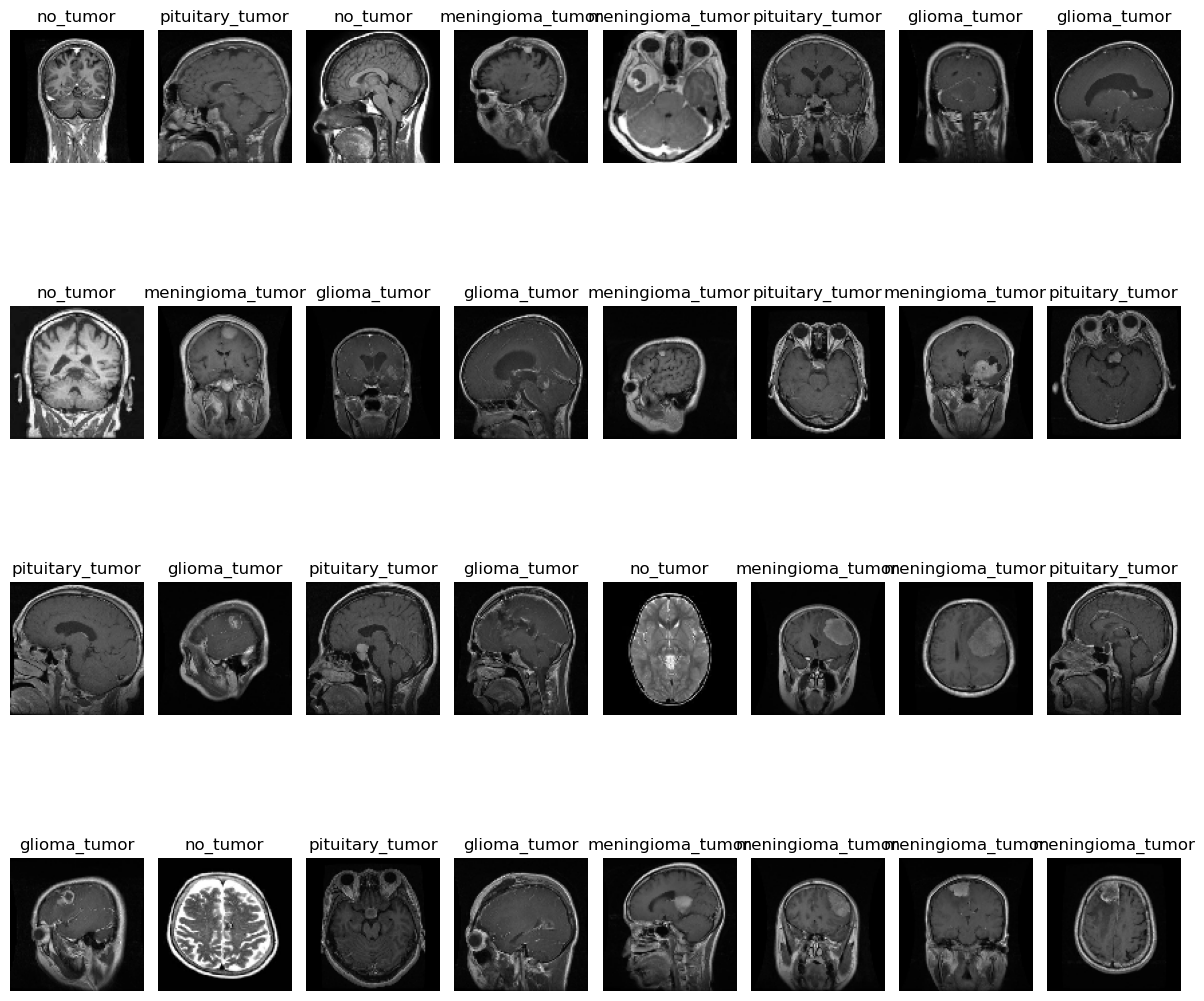

In [28]:
plt.figure(figsize=(12, 12))

class_dict = {0:"glioma_tumor", 1:"meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"  }

for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [34]:
# 가중치 imagenet으로 설정
pre_trained_model = MobileNet(weights = "imagenet", include_top=False, 
                             input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

### 모델구축

In [37]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())  # Flatten 대신 사용

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
          
model.add(Dense(train_generator.num_classes, activation="softmax"))
          
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(1e-5), metrics = ["acc"]) 

# colab ver.

# model.compile(loss="sparse_categorical_crossentropy",
#              optimizer=Adam(2e-5), metrics = ["acc"]) 

In [39]:
start_time = datetime.now()

result = model.fit(train_generator, epochs= 3, validation_data=test_generator)

end_time = datetime.now()
print("걸린시간 : ", end_time-start_time)

# colab ver

# start_time = datetime.now()

# result = model.fit(train_generator, epochs= 20, validation_data=test_generator)

# end_time = datetime.now()
# print("걸린시간 : ", end_time-start_time)

Epoch 1/3
90/90 [==============================] - 108s 1s/step - loss: 1.9793 - acc: 0.3091 - val_loss: 1.4884 - val_acc: 0.3147
Epoch 2/3
90/90 [==============================] - 95s 1s/step - loss: 1.4995 - acc: 0.4373 - val_loss: 1.4256 - val_acc: 0.3629
Epoch 3/3
90/90 [==============================] - 111s 1s/step - loss: 1.2791 - acc: 0.5098 - val_loss: 1.4070 - val_acc: 0.3858
걸린시간 :  0:05:14.886581


### 그래프

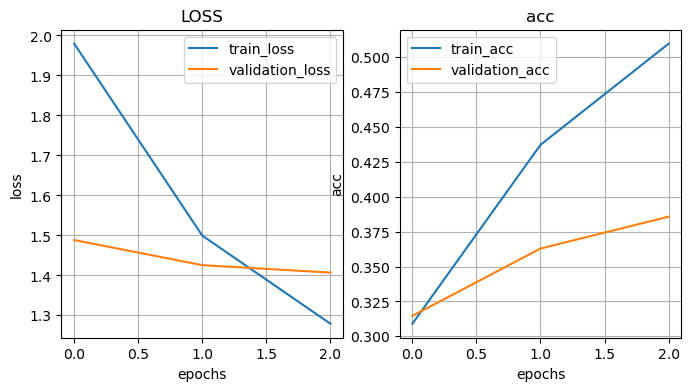

In [40]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")
plt.show()


### test

In [42]:
model.evaluate(test_generator)

13/13 [==============================] - 3s 219ms/step - loss: 1.4070 - acc: 0.3858


[1.4070329666137695, 0.3857868015766144]

# project-2

### Testing 디렉토리의 모든 파일을 Training 동일 디렉토리로 move

- project1의 정답 및 전체 데이터 갯수 확인에 추가

In [4]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [5]:
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num+1
        
    print(str(move_num) +"is moved into" + label_name+\
         "(Testing => Training)")

100is moved intoglioma_tumor(Testing => Training)
115is moved intomeningioma_tumor(Testing => Training)
105is moved intono_tumor(Testing => Training)
74is moved intopituitary_tumor(Testing => Training)


### move 완료된 training 전체 데이터 갯수 확인

In [6]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name, " -> ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train label :  glioma_tumor  ->  926
train label :  meningioma_tumor  ->  937
train label :  no_tumor  ->  396
train label :  pituitary_tumor  ->  901


### Shuffle 후 다시 Testing 으로 이동

In [7]:
#### move할 파일의 비율

MOVE_RATIO = 0.2

In [8]:
TRAIN_DATA_ROOT_DIR =  os.path.join(DATA_ROOT_DIR, "Training")
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    
    train_data_file_list = os.listdir(src)
    
    print("-------------------------------------------")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split_num : ", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_nums = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1
        
    print("total move num : ", move_num)

-------------------------------------------
total [glioma_tumor] data file nums => [926]
train data shuffle is done
split_num :  185
total move num :  259
-------------------------------------------
total [meningioma_tumor] data file nums => [937]
train data shuffle is done
split_num :  187
total move num :  446
-------------------------------------------
total [no_tumor] data file nums => [396]
train data shuffle is done
split_num :  79
total move num :  525
-------------------------------------------
total [pituitary_tumor] data file nums => [901]
train data shuffle is done
split_num :  180
total move num :  705


In [9]:
# Image Shape 설정
# 이미지 사이즈의 평균에 맞게 설정해주는것이 가장 유리

IMG_WIDTH = 244 # colab 에서는 조금더 높게 설정해보기 ex) 244
IMG_HEIGHT = 244
# ImageDataGenerator를 이용하여 데이터 불러오기

train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(TRAIN_DATA_ROOT_DIR,
                                                     batch_size = 32,
                                                     color_mode = "rgb",
                                                     class_mode = "sparse",
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT))

test_generator = train_data_gen.flow_from_directory(TEST_DATA_ROOT_DIR,
                                                     batch_size= 32,
                                                     color_mode = "rgb",
                                                     class_mode = "sparse",
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT))



Found 2529 images belonging to 4 classes.
Found 631 images belonging to 4 classes.


In [10]:
# Fine Tunning을 위한 pre-trained 정의 및 모델 구축

pre_trained_model = MobileNet(weights = "imagenet", include_top=False, 
                             input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 122, 122, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 122, 122, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 122, 122, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 122, 122, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 122, 122, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 15, 15, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 15, 15, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 15, 15, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 15, 15, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 15, 15, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 15, 15, 512)       0         
                                                                 
 conv_pw_9

In [ ]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())  # Flatten 대신 사용

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
          
model.add(Dense(train_generator.num_classes, activation="softmax"))
          
model.summary()

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(2e-5), metrics = ["acc"]) 

In [ ]:
start_time = datetime.now()

result = model.fit(train_generator, epochs= 30, validation_data=test_generator)

end_time = datetime.now()
print("걸린시간 : ", end_time-start_time)

# [0.22925344109535217, 0.9163732528686523]

# Project-3
- OpenCV를 이용하여 데이터를 로드하고 train data와 test data를 생성한 후에 TL을 이용해서 오버피팅이 최소가 될수 있도록 90% 이상의 정확도를 달성하시오

In [22]:
IMG_WIDTH = 100 # colab 에서는 조금더 높게 설정해보기 ex) 244
IMG_HEIGHT = 100

train_data_list = []
train_label_list = []

class_dict = {"glioma_tumor":0, "meningioma_tumor":1, "no_tumor":2, "pituitary_tumor":3  }

image_label_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for image_label in image_label_list:
    file_path = os.path.join(TRAIN_DATA_ROOT_DIR, image_label)
    image_file_list=glob.glob(file_path + "/*.jpg")
    
    width_list = []
    height_list = []
    
    for image_file in image_file_list:
        src_img = cv2.imread(image_file, cv2.IMREAD_COLOR)
        # print(src_img.shape)
        
        width_list.append(src_img.shape[0])
        height_list.append(src_img.shape[1])
        
        src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        train_data_list.append(src_img)
        train_label_list.append(float(class_dict[image_label]))
        
    width_arr = np.array(width_list)
    height_arr = np.array(height_list)

print("=====================================")

print("label =", image_label)
print("width average =", np.round(np.average(width_arr), 2))
print("height average =", np.round(np.average(height_arr), 2))
print("width std =", np.round(np.std(width_arr), 2))
print("height std =", np.round(np.std(height_arr), 2))
print("width max =", np.round(np.max(width_arr)))
print("height max =", np.round(np.max(height_arr)))
print("width min =", np.round(np.min(width_arr)))
print("height min =", np.round(np.min(height_arr)))

width_arr =None
height_arr = None
width_list = None
height_lsit = None

label = pituitary_tumor
width average = 517.43
height average = 518.06
width std = 112.76
height std = 117.67
width max = 1322
height max = 1358
width min = 202
height min = 201


In [19]:
X_train = np.array(train_data_list).astype("float32")
y_train = np.array(train_label_list).astype("float32")

print(X_train.shape, y_train.shape)

(2529, 100, 100, 3) (2529,)


In [20]:
#### train 데이터에서 20% 비율만큼 test 생성

MOVE_RATIO = 0.2

split_nums = int(MOVE_RATIO * len(X_train))
print("split nums : ", split_nums)

# shuffle
s = np.arange(len(X_train))
np.random.shuffle(s)

X_train = X_train[s]
y_train = y_train[s]

# test 데이터 생성
X_test = X_train[:split_nums]
y_test = y_train[:split_nums]

X_train = X_train[split_nums:]
y_train = y_train[split_nums:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

split nums :  505
(2024, 100, 100, 3) (2024,)
(505, 100, 100, 3) (505,)


### 정규화

In [21]:
X_train = X_train.astype(np.float32)/255.0
X_test = X_test.astype(np.float32)/255.0

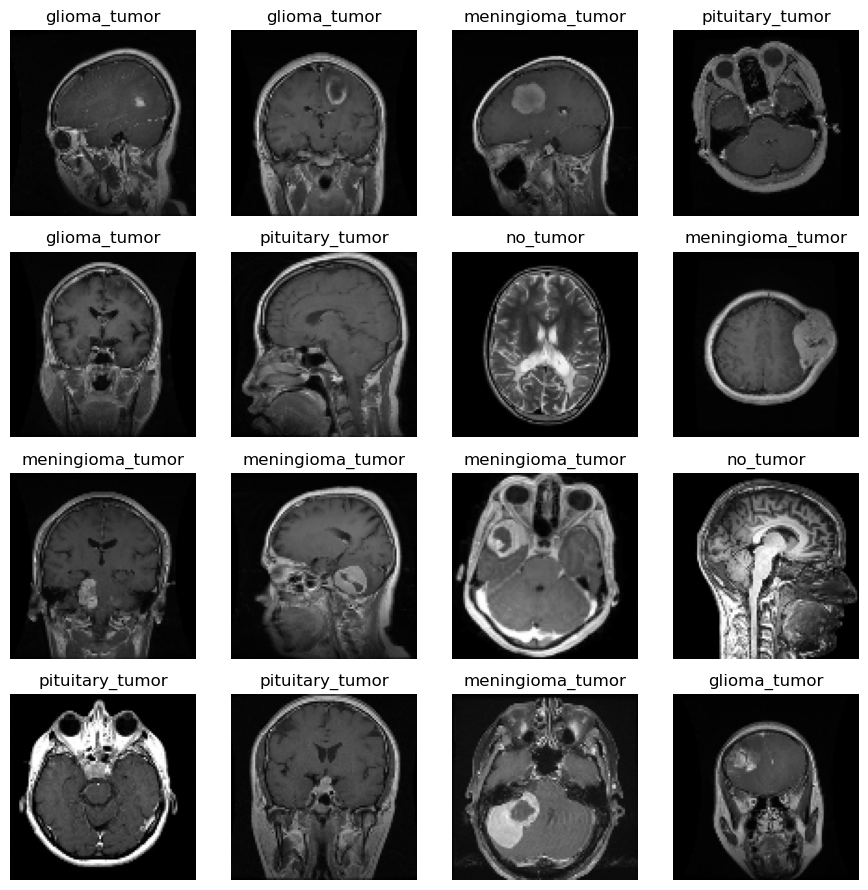

In [23]:
# 16개의 이미지 확인

class_name = {0:"glioma_tumor", 1:"meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

plt.figure(figsize=(9, 9))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(class_name[int(y_train[i])])
plt.tight_layout()

In [ ]:
# 모델수정 및 FC 계층 수정 , learning_rate 수정

### 최종 모델

- InceptionV3(weights = "imagenet", include_top=False)
- FDDDD
    - 은닉층1 : 256
    - 은닉층2 : 256
    - 은닉층3 : 128
    - DROPOUT : 0.5
    - softmax
    - optimizer=Adam(2e-5)
    - validation_data : Test 데이터
    - epoch : 30
- model.evaluate(test_generator)   
    - [0.0669158399105072, 0.9892163872718811]

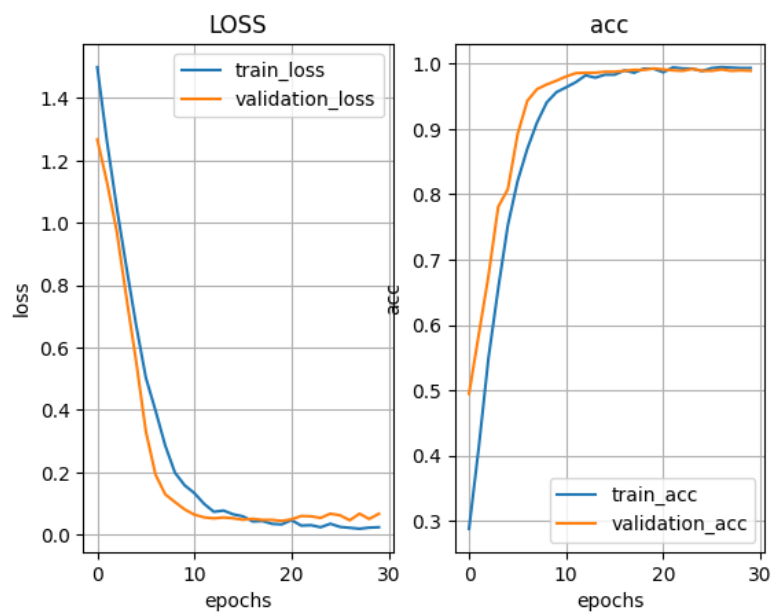